# Analyze Variables

Now that we have data, what is there?

For this, I break it down into a few steps:

* Identify the types of variables
* Have the variable describe itself (univariate analysis)
* Compare the variable to other variables (bivariate analysis)

## Default Dependencies (Again)

These are the same dependencies I typically use...sloppily, quickly.

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
figsize(11,9)

import scipy.stats as stats

import pymc as pm

In [2]:
import requests

from os.path import join, dirname
import os
from dotenv import load_dotenv, find_dotenv

dotenv_path = join(dirname('__file__'), '.env')
load_dotenv(dotenv_path)

API_KEY = os.environ.get("API_KEY")

Also, here are some data frames, pre-loaded.

In [3]:
git_logs_filename = 'data/popular_open_source_logs.csv'
columns = ['timestamp', 'project', 'email', 'lines_inserted', 'lines_removed']
git_logs = pd.read_csv(git_logs_filename, index_col='timestamp', usecols=columns)

posts_filename = "data/posts-2016-06-08-21-35-42.csv"
columns = ['Author', 'Time', 'Text', 'ProfileUrl', 'PostUrl', 'Lang',
           'Sentiment']
posts = pd.read_csv(posts_filename, parse_dates=['Time'], index_col='Time', usecols=columns)
posts['HourOfDay'] = posts.index.hour
posts['DayOfWeek'] = posts.index.dayofweek

alternate_posts_filename = "data/alt_posts-2016-06-06.csv"
columns = ['UniversalMessageId', 'SenderUserId', 'Title', 'Message',
           'CreatedTime', 'Language', 'LanguageCode', 'CountryCode',
           'MediaTypeList', 'Permalink', 'Domain', 'Spam', 'Action Time', 'Location']
alternate_posts = pd.read_csv(alternate_posts_filename,
                              usecols=columns,
                              index_col='CreatedTime',
                              parse_dates=['CreatedTime'])
alternate_posts.MediaTypeList.fillna(value='Unknown', inplace=True)
alternate_posts.SenderUserId.fillna(value='Unknown', inplace=True)

# This is a County Business Patterns API endpoint
url = "http://api.census.gov/data/2014/cbp?key=%s&get=EMP,ESTAB,EMPSZES,EMPSZES_TTL,PAYANN&for=state:*" % (API_KEY)
result = requests.get(url)
result.reason
cbp = None
if result.ok:
    data = result.json()
    cbp = pd.DataFrame(data[1:], columns=data[0])
print(result.reason)

OK


## Identify Variables

There are all kinds of variables.

Predictor variables, Independent variables, sometimes Stochastic variables are all types of input parameters to our models.  Target variables, Dependent variables, Deterministic variables are all types of output variables to our models.  This is just taking a look at how we might use the data once we have it.

The main breakdown between variables for exploratory analysis is whether it is categorical or continuous.

In [4]:
git_logs.dtypes

project           object
email             object
lines_inserted     int64
lines_removed      int64
dtype: object

In [5]:
git_logs.head()

,project,email,lines_inserted,lines_removed
timestamp,,,,
1034527543,blender,hans@lambermont.dyndns.org,1389,0
1034710347,blender,hans@lambermont.dyndns.org,11,4
1034889370,blender,nlin@nlin.net,1,1
1034951794,blender,nlin@nlin.net,45,21
1034953322,blender,nlin@nlin.net,21829,0


For our git logs, the project name and email is **categorical** and the timestamp, lines inserted, and removed are **continuous**.  Notice our continuous columns are whole values in this case.  Most of our exploration won't need to make a distinction on that.  When I break out the timestamp by hour or day of the week, I'm using them as categorical values.  I'm trying to group and compare performance for the way humans like to behave rather than measure the sum of hours or days.

## Univariate Analysis

So, univariate == one variable.  Just by looking at a variable directly, I can figure out a lot about it.  The kind of analysis that works depends on the kind of variable.

### Continuous Variables

For continuous variables, I'm interested in:

* Central tendency
* Dispersion
* Histograms
* Box plots
* Scatterplots

To set that up, let's take the git committers and count the net lines added.  That takes some group work that I talk about more in the Structure the Dataset notebook.  Here's the code for that:

In [13]:
git_logs['lines_diff'] = git_logs['lines_inserted'].shift(-1) - git_logs['lines_removed']
committer_group = git_logs.groupby(['email'])
lines_committed = pd.DataFrame(data=committer_group['lines_diff'].count())

Basic central tendency can be shown with:

In [14]:
lines_committed.describe()

,lines_diff
count,4666.000000
mean,43.290184
std,497.788020
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,22998.000000


So, this means:

* 4,666 people committed code to these 10 projects
* On average, they committed 43 lines each
* The median is only 2 lines of code, so we have a strong skew to the data
* There is an incredibly high maximum contribution (more on that later)

We can see what this looks like with a histogram:

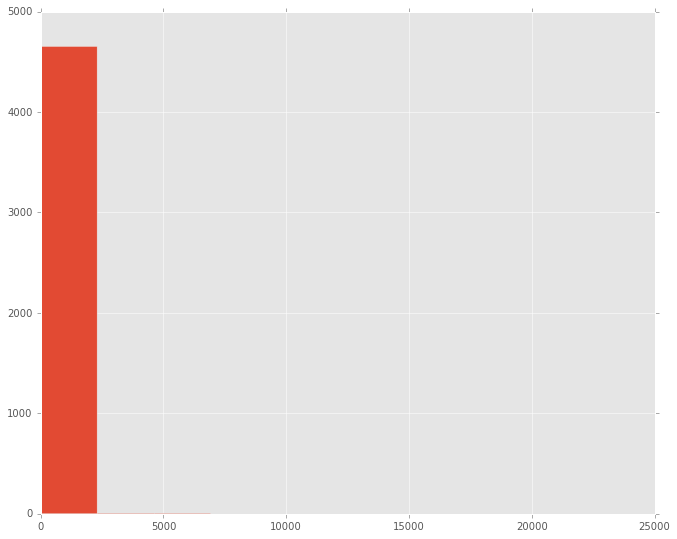

In [65]:
lines_committed.lines_diff.hist()

This isn't very useful.  However, it's not due to regular types of outliers.  There are a few people that have committed incredible amounts to these projects and a lot of people that have done small contributions.  In this case, let's take the lower 80% of the contributors and see what that looks like.

In [50]:
boundary = lines_committed.lines_diff.quantile(0.80)
lower_portion = lines_committed.loc[lines_committed.lines_diff <= boundary]
lower_portion.describe()

,lines_diff
count,3738.000000
mean,2.000803
std,1.636403
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,8.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e1ec9b0>]], dtype=object)

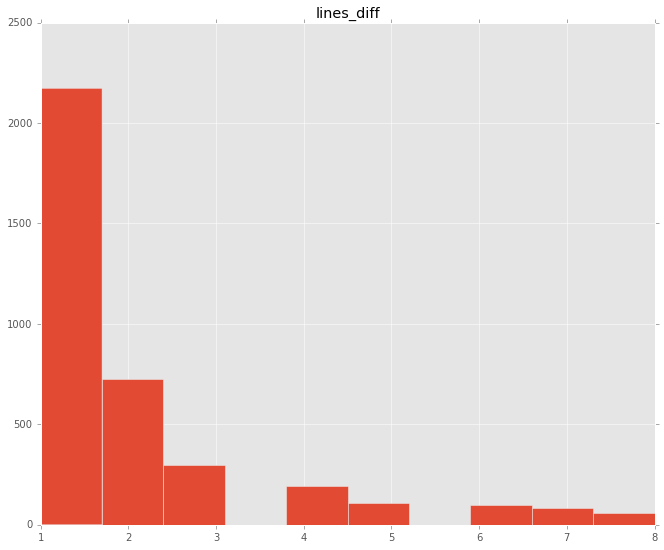

In [63]:
lower_portion.hist()

What we see is 3,738 people committed 8 lines or fewer to thee projects.  That makes up 80% of the contributors on the projects.  Let's take a look at the upper 20%.

In [52]:
upper_portion = lines_committed.loc[lines_committed.lines_diff > boundary]
upper_portion.describe()

,lines_diff
count,928.000000
mean,209.604526
std,1101.094107
min,9.000000
25%,15.000000
50%,32.000000
75%,105.000000
max,22998.000000


We still have a hard time seeing these people.  There are 928 of them.  They are still distributed to a small group of elites.  Let's do a log transform on this data instead.

count    4666.000000
mean        0.490842
std         0.684472
min         0.000000
25%         0.000000
50%         0.301030
75%         0.778151
max         4.361690
Name: lines_diff, dtype: float64

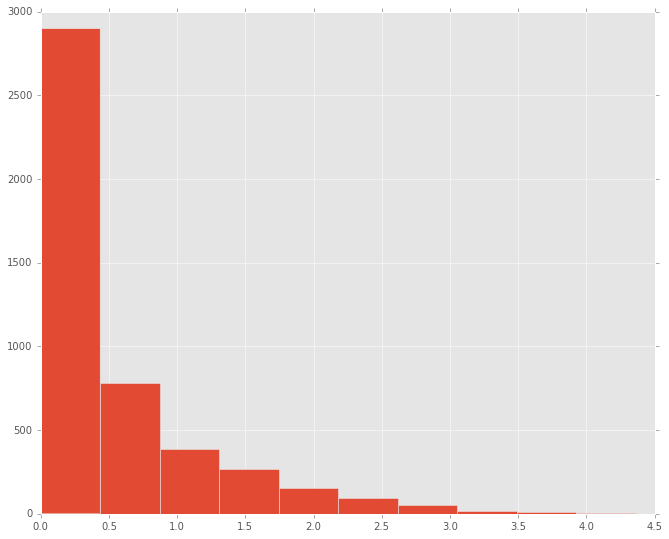

In [66]:
log_count = lines_committed.lines_diff.apply(np.log10)
log_count.hist()
log_count.describe()

Another way to see this data is with a boxplot:

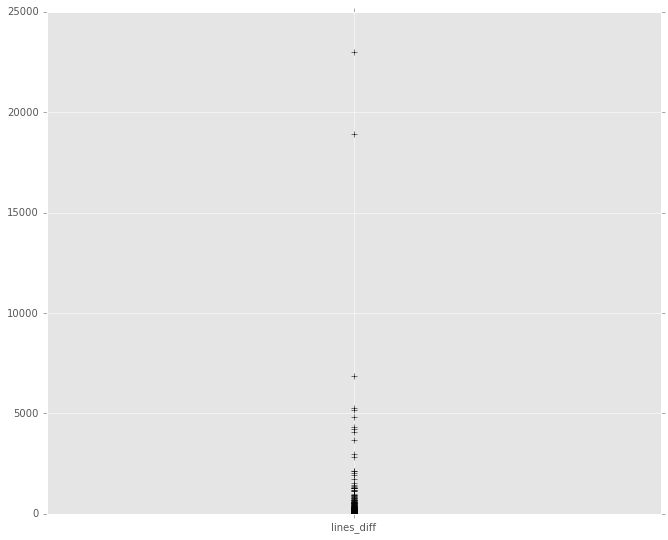

In [69]:
lines_committed.boxplot(return_type='axes')

### Categorical Variables

The categorical variables can benefit from a count and count percentage of each category.

In [73]:
git_logs.columns

Index(['project', 'email', 'lines_inserted', 'lines_removed', 'lines_diff'], dtype='object')

In [84]:
project_group = git_logs.groupby('project')
commit_counts = project_group.project.apply(lambda x: x.count())
commit_count_portion = list(map(lambda x: x / commit_counts.sum(), commit_counts))
count_df = pd.DataFrame(data={'commit_count': commit_counts, 'proportion': commit_count_portion})
count_df

,commit_count,proportion
project,,
blender,62397,0.308904
d3,3035,0.015025
dolphin,16863,0.083482
git,32768,0.162222
piwik,20769,0.102819
platform,4378,0.021674
r-source,39284,0.194480
spark,14877,0.073650
sugarcrm_dev,56,0.000277


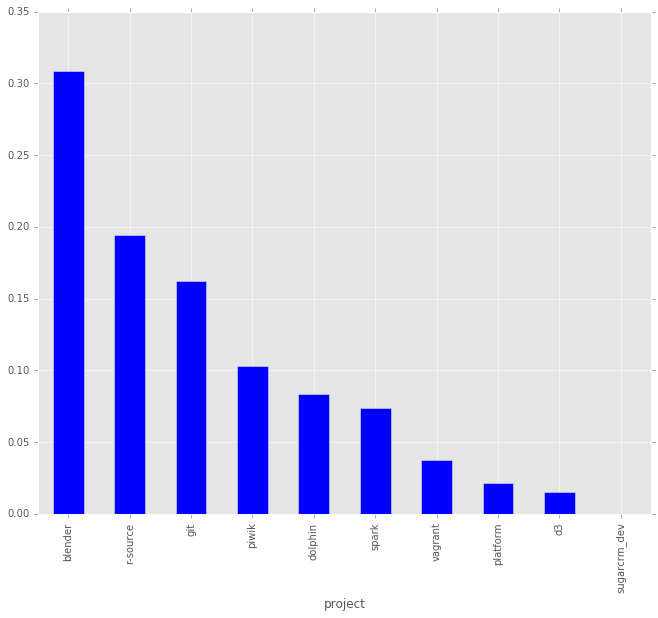

In [92]:
count_df.proportion.sort_values(ascending=False).plot(kind='bar')

## Bivariate Analysis

Once the data starts to make sense, it can be more interesting to see how things relate. 

### Continuous to Continuous

Comparing continuous values is often quite easy.  In our posts data frame, we only have our newly-added columns that are continuous (so the scatterplot is simple):

True

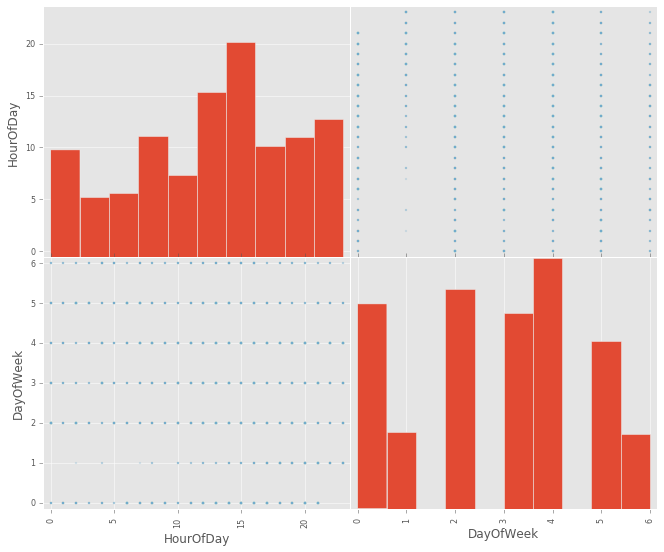

In [96]:
pd.tools.plotting.scatter_matrix(posts, alpha=0.2)
True

Here, we can only see a weak bivariate comparison on Monday mornings.

,project,email,lines_inserted,lines_removed,lines_diff
timestamp,,,,,
1034527543,blender,hans@lambermont.dyndns.org,1389,0,11
1034710347,blender,hans@lambermont.dyndns.org,11,4,-3
1034889370,blender,nlin@nlin.net,1,1,44
1034951794,blender,nlin@nlin.net,45,21,21808
1034953322,blender,nlin@nlin.net,21829,0,1419


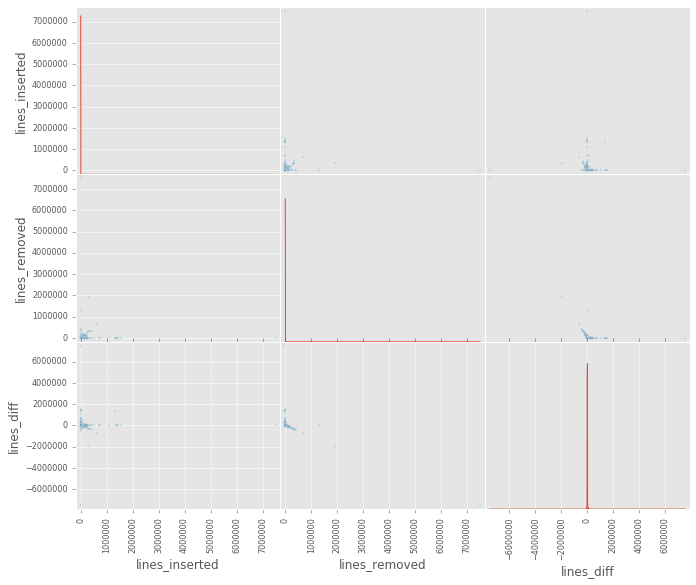

In [99]:
pd.tools.plotting.scatter_matrix(git_logs, alpha=0.2, diagonal='kde')
git_logs.head()